In [35]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

讀取資料

In [21]:
with open('../data/output_clean_date_technical.json', 'r') as file:
    data = json.load(file)

merged_dict = {}

for item in data:
  if item == "historicalPriceFull":
    symbol = ""
    for entry in data[item]:
        if "symbol" in entry:
            symbol = data[item][entry]
        else:
            df = pd.json_normalize(data[item][entry])
            df["symbol"] = symbol
  else:
     df = pd.json_normalize(data[item])
  
  merged_dict[item] = df

In [24]:
stockprice_df = merged_dict["historicalPriceFull"]
stockprice_df

,date,open,high,low,close,adjClose,volume,unadjustedVolume,change,changePercent,vwap,label,changeOverTime,symbol
0,2024-01-12,33.70,33.80,33.60,33.75,33.750000,5221622,5221622,0.05,0.14837,33.72,"January 12, 24",0.001484,1101.TW
1,2024-01-11,33.70,33.80,33.60,33.70,33.700000,6590499,6590499,0.00,0.00000,33.70,"January 11, 24",0.000000,1101.TW
2,2024-01-10,34.05,34.05,33.70,33.70,33.700000,10231832,10231832,-0.35,-1.03000,33.82,"January 10, 24",-0.010300,1101.TW
3,2024-01-09,34.30,34.30,34.05,34.05,34.050000,6191243,6191243,-0.25,-0.72886,34.13,"January 09, 24",-0.007289,1101.TW
4,2024-01-08,34.40,34.55,34.25,34.25,34.250000,5522713,5522713,-0.15,-0.43605,34.35,"January 08, 24",-0.004360,1101.TW
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
731,2021-01-20,37.87,37.91,37.09,37.23,33.397839,38529978,38529978,-0.64,-1.69000,37.41,"January 20, 21",-0.016900,1101.TW
732,2021-01-19,37.82,38.18,37.82,37.96,34.050301,13261660,13261660,0.14,0.37017,37.99,"January 19, 21",0.003702,1101.TW
733,2021-01-18,38.14,38.14,37.64,37.82,33.927963,27598255,27598255,-0.32,-0.83901,37.87,"January 18, 21",-0.008390,1101.TW
734,2021-01-15,38.64,38.64,38.14,38.14,34.213417,33681520,33681520,-0.50,-1.29000,38.31,"January 15, 21",-0.012900,1101.TW


---

確認資料狀況

In [25]:
stockprice_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 736 entries, 0 to 735
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   date              736 non-null    object 
 1   open              736 non-null    float64
 2   high              736 non-null    float64
 3   low               736 non-null    float64
 4   close             736 non-null    float64
 5   adjClose          736 non-null    float64
 6   volume            736 non-null    int64  
 7   unadjustedVolume  736 non-null    int64  
 8   change            736 non-null    float64
 9   changePercent     736 non-null    float64
 10  vwap              736 non-null    float64
 11  label             736 non-null    object 
 12  changeOverTime    736 non-null    float64
 13  symbol            736 non-null    object 
dtypes: float64(9), int64(2), object(3)
memory usage: 80.6+ KB


In [26]:
# check date
stockprice_df['label_date'] = pd.to_datetime(stockprice_df['label'])
stockprice_df['date'] = pd.to_datetime(stockprice_df['date'])
print(f"Number of 'label_date != date': {len(stockprice_df[stockprice_df['label_date'] != stockprice_df['date']])}")

Number of 'label_date != date': 0


/tmp/ipykernel_665124/304800840.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  stockprice_df['label_date'] = pd.to_datetime(stockprice_df['label'])


In [27]:
# check if any columns is NaN
print(f"Number of NaN:\n{stockprice_df.isna().sum()}")

Number of NaN:
date                0
open                0
high                0
low                 0
close               0
adjClose            0
volume              0
unadjustedVolume    0
change              0
changePercent       0
vwap                0
label               0
changeOverTime      0
symbol              0
label_date          0
dtype: int64


In [28]:
# check if duplicate
print(f"Number of duplicate: {len(stockprice_df[stockprice_df.duplicated()])}")

Number of duplicate: 0


尋找相關性

In [30]:
# 去除不考慮的欄位
stockprice_df.drop(columns=['label', 'label_date'], inplace=True)

In [43]:
# 假設 stockprice_df 已經被讀取並包含所有必要的欄位
stockprice_df['date'] = pd.to_datetime(stockprice_df['date'])
stockprice_df = stockprice_df.sort_values(['symbol', 'date'])

# 創建90天後的收盤價目標變量
stockprice_df['close_90d'] = stockprice_df.groupby('symbol')['close'].shift(-90)

# 移除close_90d是NaN的行
stockprice_df = stockprice_df[stockprice_df['close_90d'].notna()]

# 定義計算相關性的函數
def calculate_correlation(group):
    group.drop(columns=['symbol', 'date'], inplace=True)
    correlation_matrix = group.corr()
    return correlation_matrix['close_90d']

# 對每個股票分組計算相關性
correlation_by_symbol = stockprice_df.groupby('symbol').apply(calculate_correlation)
print(correlation_by_symbol)

close_90d      open      high       low     close  adjClose    volume  \
symbol                                                                  
1101.TW    0.538489  0.541924  0.535744  0.539279  0.336895  0.160779   

close_90d  unadjustedVolume    change  changePercent      vwap  \
symbol                                                           
1101.TW            0.160779  0.030436       0.039478  0.539604   

close_90d  changeOverTime  close_90d  
symbol                                
1101.TW          0.039478        1.0  


/tmp/ipykernel_665124/352484562.py:18: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  correlation_by_symbol = stockprice_df.groupby('symbol').apply(calculate_correlation)


1101.TW correlation: close_90d
open                0.538489
high                0.541924
low                 0.535744
close               0.539279
adjClose            0.336895
volume              0.160779
unadjustedVolume    0.160779
change              0.030436
changePercent       0.039478
vwap                0.539604
changeOverTime      0.039478
close_90d           1.000000
Name: 1101.TW, dtype: float64


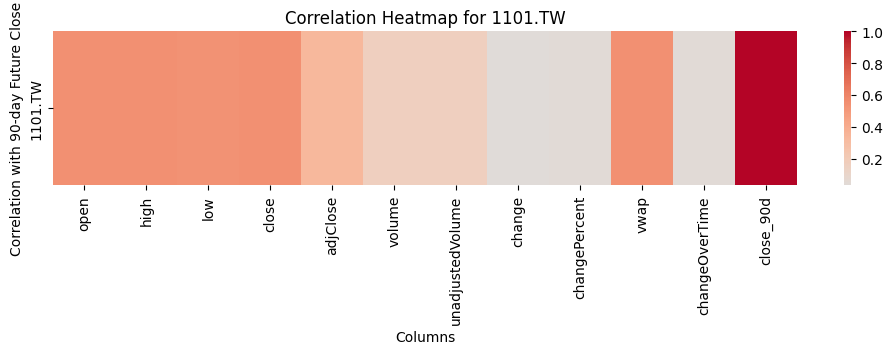

In [51]:
symbols = stockprice_df['symbol'].unique()

for symbol in symbols:
    symbol_corr = correlation_by_symbol.loc[symbol]
    print(f"{symbol} correlation: {symbol_corr}")
    
    plt.figure(figsize=(12, 2))
    sns.heatmap(correlation_by_symbol, cmap='coolwarm', center=0)
    plt.title(f'Correlation Heatmap for {symbol}')
    plt.xlabel('Columns')
    plt.ylabel('Correlation with 90-day Future Close Price')
    plt.show()

